In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import mlrose_hiive as mlr
from mlrose_hiive import Knapsack, DiscreteOpt, random_hill_climb
from mlrose_hiive import SARunner, GARunner, RHCRunner, NNGSRunner
from array import array
import importlib
import numpy as np
import helpers #import the module here, so that it can be reloaded.
import loader
import plot
importlib.reload(helpers)
importlib.reload(loader)
importlib.reload(plot)
import time
import joblib
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split, StratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, learning_curve
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data = loader.load_cancer_data()
features = [col for col in data.columns if col != "target"]
X = data[features]
y = data["target"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [4]:
# Normalize input data
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

In [115]:
len(X_test_norm)

171

In [125]:
y_test.value_counts()

0    107
1     64
Name: target, dtype: int64

In [56]:
iterations = [1000, 2500, 5000]
attempts = [25, 50]
restarts = [10, 50]
labels = ['max_attempts', 'max_iters', 'restarts', 'run_time', 'accuracy', 'error']
results_list = []
for max_iter in iterations:
    for a in attempts:
        for r in restarts:
            start_time = time.perf_counter()
            model = mlr.NeuralNetwork(
                hidden_nodes=[len(features)],
                is_classifier=True,
                learning_rate=0.1,
                early_stopping=True,
                random_state=12345,
                algorithm='random_hill_climb',
                max_iters=max_iter,
                max_attempts=a,
                restarts=r
            )
            model.fit(X_train_norm, y_train)
            run_time = time.perf_counter() - start_time
            y_test_pred = model.predict(X_test_norm)
            y_test_accuracy = accuracy_score(y_test, y_test_pred)
            y_test_error = 1.0 - y_test_accuracy
            y_test_confusion = confusion_matrix(y_test, y_test_pred)
            joblib.dump(y_test_confusion, f"nn/rhc/confusion,iter{max_iter},a{a},r{r}.pkl")
            results_list.append((a, max_iter, r, run_time, y_test_accuracy, y_test_error))

rhc_results = pd.DataFrame.from_records(results_list, columns=labels)
joblib.dump(rhc_results, "nn/rhc/rhc_results.pkl")

['nn/rhc/rhc_results.pkl']

In [58]:
rhc_results.sort_values(by="error")

,max_attempts,max_iters,restarts,run_time,accuracy,error
5,25,2500,50,207.805085,0.912281,0.087719
7,50,2500,50,223.011564,0.912281,0.087719
4,25,2500,10,42.508135,0.883041,0.116959
6,50,2500,10,43.241490,0.883041,0.116959
8,25,5000,10,93.424847,0.871345,0.128655
9,25,5000,50,470.092433,0.871345,0.128655
10,50,5000,10,106.087570,0.871345,0.128655
11,50,5000,50,464.727309,0.871345,0.128655
1,25,1000,50,70.116922,0.801170,0.198830
3,50,1000,50,77.856621,0.801170,0.198830


In [41]:
iterations = [1000, 2500, 5000]
attempts = [100, 300]
temps = [0.1, 1, 10, 100]
labels = ['max_attempts', 'max_iters', 'temp', 'run_time', 'accuracy', 'error']
results_list = []
for max_iter in iterations:
    for a in attempts:
        for temp in temps:
            start_time = time.perf_counter()
            model = mlr.NeuralNetwork(
                hidden_nodes=[len(features)],
                is_classifier=True,
                learning_rate=0.1,
                early_stopping=True,
                random_state=12345,
                algorithm='simulated_annealing',
                max_iters=max_iter,
                max_attempts=a,
                schedule=mlr.GeomDecay(init_temp=temp)
            )
            model.fit(X_train_norm, y_train)
            run_time = time.perf_counter() - start_time
            y_test_pred = model.predict(X_test_norm)
            y_test_accuracy = accuracy_score(y_test, y_test_pred)
            y_test_error = 1.0 - y_test_accuracy
            y_test_confusion = confusion_matrix(y_test, y_test_pred)
            joblib.dump(y_test_confusion, f"nn/sa/confusion,iter{max_iter},a{a},temp{temp}.pkl")
            results_list.append((a, max_iter, temp, run_time, y_test_accuracy, y_test_error))

sa_results = pd.DataFrame.from_records(results_list, columns=labels)
joblib.dump(sa_results, "nn/sa/sa_results.pkl")

['nn/sa/sa_results.pkl']

In [42]:
sa_results.sort_values(by="error")

,max_attempts,max_iters,temp,run_time,accuracy,error
20,300,5000,0.1,11.695383,0.906433,0.093567
18,100,5000,10.0,12.343274,0.906433,0.093567
16,100,5000,0.1,11.128593,0.906433,0.093567
22,300,5000,10.0,14.554224,0.906433,0.093567
23,300,5000,100.0,12.886700,0.900585,0.099415
19,100,5000,100.0,12.427985,0.900585,0.099415
21,300,5000,1.0,12.442989,0.894737,0.105263
17,100,5000,1.0,11.539724,0.894737,0.105263
9,100,2500,1.0,3.881805,0.853801,0.146199
13,300,2500,1.0,5.027621,0.853801,0.146199


In [43]:
pcts = [0.1, 0.2, 0.4, 0.6, 0.8]
pops = [100, 200, 300, 400]
iterations = [1000, 2500, 5000]
labels = ['max_iters', 'population_size', 'mutation_percentag', 'run_time', 'accuracy', 'error']
results_list = []
for max_iter in iterations:
    for pop in pops:
        for pct in pcts:
            start_time = time.perf_counter()
            model = mlr.NeuralNetwork(
                hidden_nodes=[len(features)],
                is_classifier=True,
                learning_rate=0.1,
                early_stopping=True,
                pop_size=pop,
                mutation_prob=pct,
                random_state=12345,
                algorithm='genetic_alg',
                max_iters=max_iter,
            )
            model.fit(X_train_norm, y_train)
            run_time = time.perf_counter() - start_time
            y_test_pred = model.predict(X_test_norm)
            y_test_accuracy = accuracy_score(y_test, y_test_pred)
            y_test_error = 1.0 - y_test_accuracy
            y_test_confusion = confusion_matrix(y_test, y_test_pred)
            joblib.dump(y_test_confusion, f"nn/ga/confusion,iter{max_iter},pop{pop},pct{pct}.pkl")
            results_list.append((max_iter, pop, pct, run_time, y_test_accuracy, y_test_error))

ga_results = pd.DataFrame.from_records(results_list, columns=labels)
joblib.dump(ga_results, "nn/ga/ga_results.pkl")

['nn/ga/ga_results.pkl']

In [44]:
ga_results.sort_values(by="error")

,max_iters,population_size,mutation_percentag,run_time,accuracy,error
59,5000,400,0.8,24.382068,0.929825,0.070175
39,2500,400,0.8,23.917940,0.929825,0.070175
19,1000,400,0.8,23.626505,0.929825,0.070175
2,1000,100,0.4,2.014083,0.918129,0.081871
22,2500,100,0.4,2.562135,0.918129,0.081871
42,5000,100,0.4,2.624834,0.918129,0.081871
35,2500,400,0.1,7.486290,0.912281,0.087719
15,1000,400,0.1,7.861278,0.912281,0.087719
55,5000,400,0.1,7.576584,0.912281,0.087719
32,2500,300,0.4,13.540491,0.906433,0.093567


In [59]:
rhc_model = mlr.NeuralNetwork(
    hidden_nodes=[len(features)],
    is_classifier=True,
    learning_rate=0.1,
    early_stopping=True,
    random_state=12345,
    algorithm='random_hill_climb',
    max_iters=2500,
    max_attempts=25,
    restarts=50
)

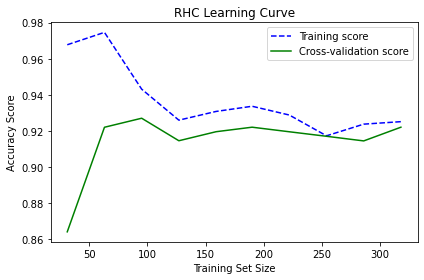

In [60]:
plot.plot_learning_curve(rhc_model, X_train_norm, y_train, title="RHC Learning Curve")

In [99]:
rhc_model = mlr.NeuralNetwork(
    hidden_nodes=[len(features)],
    is_classifier=True,
    learning_rate=0.1,
    early_stopping=True,
    random_state=12345,
    algorithm='random_hill_climb',
    max_iters=2500,
    max_attempts=25,
    restarts=50,
    curve=True
)
rhc_model.fit(X_train_norm, y_train)

NeuralNetwork(curve=True, early_stopping=True, hidden_nodes=[30],
              max_attempts=25, max_iters=2500, random_state=12345, restarts=50)

In [100]:
rhc_model.loss

0.2660715253108015

In [101]:
rhc_y_test_pred = rhc_model.predict(X_test_norm)
rhc_y_test_accuracy = accuracy_score(y_test, rhc_y_test_pred)
rhc_y_test_accuracy

0.9122807017543859

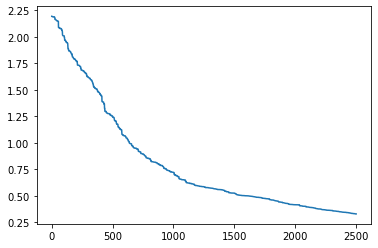

In [102]:
plt.plot(range(1, len(rhc_model.fitness_curve) + 1), helpers.extract(rhc_model.fitness_curve))

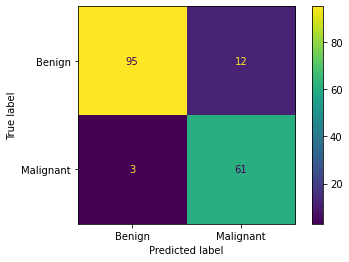

In [116]:
rhc_confusion = joblib.load(f"nn/rhc/confusion,iter{2500},a{25},r{50}.pkl")
disp = ConfusionMatrixDisplay(confusion_matrix=rhc_confusion, display_labels=["Benign", "Malignant"])
disp.plot()

In [61]:
sa_model = mlr.NeuralNetwork(
    hidden_nodes=[len(features)],
    is_classifier=True,
    learning_rate=0.1,
    early_stopping=True,
    random_state=12345,
    algorithm='simulated_annealing',
    max_iters=5000,
    max_attempts=300,
    schedule=mlr.GeomDecay(init_temp=0.1)
)

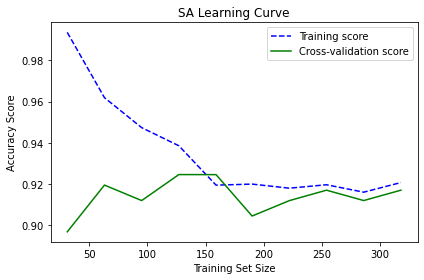

In [62]:
plot.plot_learning_curve(sa_model, X_train_norm, y_train, title="SA Learning Curve")

In [108]:
sa_model = mlr.NeuralNetwork(
    hidden_nodes=[len(features)],
    is_classifier=True,
    learning_rate=0.1,
    early_stopping=True,
    random_state=12345,
    algorithm='simulated_annealing',
    max_iters=5000,
    max_attempts=300,
    schedule=mlr.GeomDecay(init_temp=0.1),
    curve=True
)
sa_model.fit(X_train_norm, y_train)

NeuralNetwork(algorithm='simulated_annealing', curve=True, early_stopping=True,
              hidden_nodes=[30], max_attempts=300, max_iters=5000,
              random_state=12345,
              schedule=GeomDecay(init_temp=0.1, decay=0.99, min_temp=0.001))

In [109]:
sa_y_test_pred = sa_model.predict(X_test_norm)
sa_y_test_accuracy = accuracy_score(y_test, sa_y_test_pred)
sa_y_test_accuracy

0.9064327485380117

In [110]:
sa_model.fitness_curve

array([[2.19951670e+00, 3.00000000e+00],
       [2.19601987e+00, 5.00000000e+00],
       [2.19598638e+00, 7.00000000e+00],
       ...,
       [2.48959426e-01, 9.26700000e+03],
       [2.48959426e-01, 9.26900000e+03],
       [2.48943393e-01, 9.27100000e+03]])

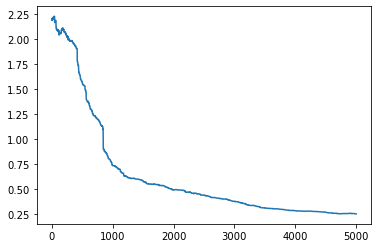

In [111]:
plt.plot(range(1, len(sa_model.fitness_curve) + 1), helpers.extract(sa_model.fitness_curve))

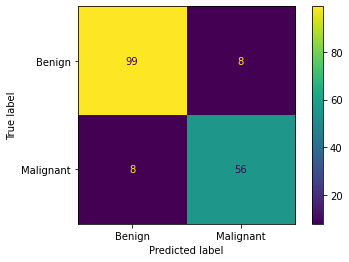

In [117]:
sa_confusion = joblib.load(f"nn/sa/confusion,iter{5000},a{300},temp{0.1}.pkl")
disp = ConfusionMatrixDisplay(confusion_matrix=sa_confusion, display_labels=["Benign", "Malignant"])
disp.plot()

In [63]:
ga_model = mlr.NeuralNetwork(
    hidden_nodes=[len(features)],
    is_classifier=True,
    learning_rate=0.1,
    early_stopping=True,
    pop_size=400,
    mutation_prob=0.8,
    random_state=12345,
    algorithm='genetic_alg',
    max_iters=1000,
)

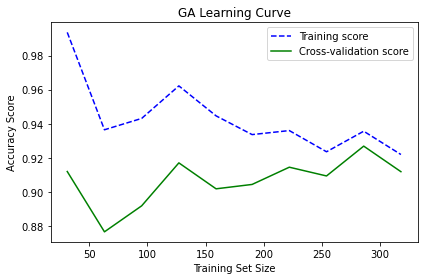

In [64]:
plot.plot_learning_curve(ga_model, X_train_norm, y_train, title="GA Learning Curve")

In [93]:
ga_model = mlr.NeuralNetwork(
    hidden_nodes=[len(features)],
    is_classifier=True,
    learning_rate=0.1,
    early_stopping=True,
    pop_size=400,
    mutation_prob=0.8,
    random_state=12345,
    algorithm='genetic_alg',
    max_iters=1000,
    curve=True
)
ga_model.fit(X_train_norm, y_train)

NeuralNetwork(algorithm='genetic_alg', curve=True, early_stopping=True,
              hidden_nodes=[30], max_iters=1000, mutation_prob=0.8,
              pop_size=400, random_state=12345)

In [94]:
ga_y_test_pred = ga_model.predict(X_test_norm)
ga_y_test_accuracy = accuracy_score(y_test, ga_y_test_pred)
ga_y_test_accuracy

0.9298245614035088

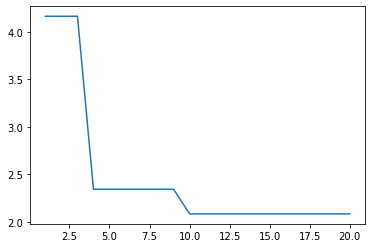

In [95]:
plt.plot(range(1, len(ga_model.fitness_curve) + 1), helpers.extract(ga_model.fitness_curve))

Text(0.5, 1.0, 'Loss over Iterations')

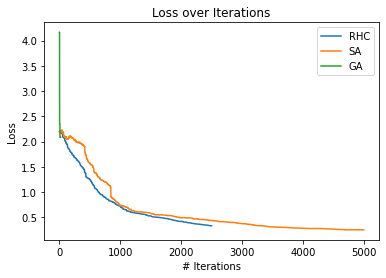

In [119]:
plt.plot(range(1, len(rhc_model.fitness_curve) + 1), helpers.extract(rhc_model.fitness_curve), label="RHC")
plt.plot(range(1, len(sa_model.fitness_curve) + 1), helpers.extract(sa_model.fitness_curve), label="SA")
plt.plot(range(1, len(ga_model.fitness_curve) + 1), helpers.extract(ga_model.fitness_curve), label="GA")
plt.legend(loc="best")
plt.xlabel("# Iterations")
plt.ylabel("Loss")
plt.title("Loss over Iterations")

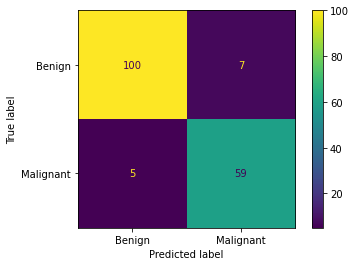

In [118]:
ga_confusion = joblib.load(f"nn/ga/confusion,iter{1000},pop{400},pct{0.8}.pkl")
disp = ConfusionMatrixDisplay(confusion_matrix=ga_confusion, display_labels=["Benign", "Malignant"])
disp.plot()

In [138]:
gd_model = mlr.NeuralNetwork(
    hidden_nodes=[len(features)],
    is_classifier=True,
    learning_rate=0.3,
    early_stopping=True,
    random_state=12345,
    algorithm='gradient_descent',
    max_iters=1000,
)
gd_model.fit(X_train_norm, y_train)

NeuralNetwork(algorithm='gradient_descent', early_stopping=True,
              hidden_nodes=[30], learning_rate=0.3, max_iters=1000,
              random_state=12345)

In [139]:
gd_y_test_pred = gd_model.predict(X_test_norm)
gd_y_test_accuracy = accuracy_score(y_test, gd_y_test_pred)
gd_y_test_accuracy

0.6257309941520468

In [134]:
params=dict(schedule=[mlr.GeomDecay(init_temp=0.1)], max_iters=[5000], activation=["relu"])
sa_runner = NNGSRunner(
    X_train_norm,
    y_train,
    X_test_norm,
    y_test,
    'sa-nn-test',
    12345,
    [1, 10, 50, 100, 250, 500, 1000, 2500, 5000, 10000],
    mlr.algorithms.sa.simulated_annealing,
    params,
    hidden_layer_sizes=[[len(features)]],
    generate_curves=True,
)
sa_results = sa_runner.run()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


NotFittedError: All estimators failed to fit

In [39]:
iterations = [100, 250, 500, 1000, 2500, 5000]
attempts = [25, 50]
restarts = [10, 50]
labels = ['max_attempts', 'max_iters', 'restarts', 'run_time', 'accuracy', 'error']
results_list = []
for max_iter in iterations:
    start_time = time.perf_counter()
    model = mlr.NeuralNetwork(
        hidden_nodes=[len(features)],
        is_classifier=True,
        learning_rate=0.1,
        early_stopping=True,
        random_state=12345,
        algorithm='random_hill_climb',
        max_iters=max_iter,
        max_attempts=25,
        restarts=50
    )
    model.fit(X_train_norm, y_train)
    run_time = time.perf_counter() - start_time
    y_test_pred = model.predict(X_test_norm)
    y_test_accuracy = accuracy_score(y_test, y_test_pred)
    y_test_error = 1.0 - y_test_accuracy
    y_test_confusion = confusion_matrix(y_test, y_test_pred)
    joblib.dump(y_test_confusion, f"nn/rhc/confusion,iter{max_iter},a{25},r{50}.pkl")
    results_list.append((a, max_iter, r, run_time, y_test_accuracy, y_test_error))

rhc_vary_iterations = pd.DataFrame.from_records(results_list, columns=labels)
joblib.dump(rhc_vary_iterations, "nn/rhc/rhc_results_vary_iteration.pkl")

KeyboardInterrupt: 

In [45]:
iterations = [50, 100, 250, 500, 1000, 1500, 2000, 2500, 5000, 7500, 10000]
labels = ['max_attempts', 'max_iters', 'temp', 'run_time', 'accuracy', 'error', 'loss']
results_list = []
attempts = 100
temp = 10.0
for max_iter in iterations:
    start_time = time.perf_counter()
    model = mlr.NeuralNetwork(
        hidden_nodes=[len(features)],
        is_classifier=True,
        learning_rate=0.1,
        early_stopping=True,
        random_state=12345,
        algorithm='simulated_annealing',
        max_iters=max_iter,
        max_attempts=attempts,
        schedule=mlr.GeomDecay(init_temp=temp)
    )
    model.fit(X_train_norm, y_train)
    run_time = time.perf_counter() - start_time
    y_test_pred = model.predict(X_test_norm)
    y_test_accuracy = accuracy_score(y_test, y_test_pred)
    y_test_error = 1.0 - y_test_accuracy
    loss = model.loss
    y_test_confusion = confusion_matrix(y_test, y_test_pred)
    joblib.dump(y_test_confusion, f"nn/sa/confusion,iter{max_iter},a{attempts},temp{temp}.pkl")
    results_list.append((attempts, max_iter, temp, run_time, y_test_accuracy, y_test_error))

sa_vary_iterations_res = pd.DataFrame.from_records(results_list, columns=labels)
joblib.dump(sa_vary_iterations_res, "nn/sa/sa_results_vary_iteration.pkl")

['nn/sa/sa_results_vary_iteration.pkl']

In [46]:
sa_vary_iterations_res

,max_attempts,max_iters,temp,run_time,accuracy,error
0,100,50,10.0,0.107813,0.374269,0.625731
1,100,100,10.0,0.187325,0.374269,0.625731
2,100,250,10.0,0.478216,0.374269,0.625731
3,100,500,10.0,0.916041,0.374269,0.625731
4,100,1000,10.0,1.738954,0.374269,0.625731
5,100,1500,10.0,2.524283,0.432749,0.567251
6,100,2000,10.0,3.364793,0.760234,0.239766
7,100,2500,10.0,4.253869,0.830409,0.169591
8,100,5000,10.0,9.090069,0.906433,0.093567


In [47]:
iterations = [50, 100, 250, 500, 1000, 1500, 2000, 2500, 5000, 7500, 10000]
labels = ['max_iters', 'population_size', 'mutation_percentag', 'run_time', 'accuracy', 'error']
results_list = []
pop = 100
mut_prob = 0.4
for max_iter in iterations:
    start_time = time.perf_counter()
    model = mlr.NeuralNetwork(
        hidden_nodes=[len(features)],
        is_classifier=True,
        learning_rate=0.1,
        early_stopping=True,
        pop_size=pop,
        mutation_prob=mut_prob,
        random_state=12345,
        algorithm='genetic_alg',
        max_iters=1000,
    )
    model.fit(X_train_norm, y_train)
    run_time = time.perf_counter() - start_time
    y_test_pred = model.predict(X_test_norm)
    y_test_accuracy = accuracy_score(y_test, y_test_pred)
    y_test_error = 1.0 - y_test_accuracy
    y_test_confusion = confusion_matrix(y_test, y_test_pred)
    joblib.dump(y_test_confusion, f"nn/ga/confusion,iter{max_iter},pop{pop},pct{mut_prob}.pkl")
    results_list.append((max_iter, pop, mut_prob, run_time, y_test_accuracy, y_test_error))

ga_vary_iterations_res = pd.DataFrame.from_records(results_list, columns=labels)
joblib.dump(ga_vary_iterations_res, "nn/ga/ga_results_vary_iteration.pkl")

['nn/ga/ga_results_vary_iteration.pkl']

In [48]:
ga_vary_iterations_res

,max_iters,population_size,mutation_percentag,run_time,accuracy,error
0,50,100,0.4,2.160429,0.918129,0.081871
1,100,100,0.4,2.097338,0.918129,0.081871
2,250,100,0.4,2.091554,0.918129,0.081871
3,500,100,0.4,2.085193,0.918129,0.081871
4,1000,100,0.4,2.116501,0.918129,0.081871
5,1500,100,0.4,2.078501,0.918129,0.081871
6,2000,100,0.4,2.072347,0.918129,0.081871
7,2500,100,0.4,2.083233,0.918129,0.081871
8,5000,100,0.4,2.070112,0.918129,0.081871
9,7500,100,0.4,2.157003,0.918129,0.081871


In [75]:
sa_model = mlr.NeuralNetwork(
    hidden_nodes=[len(features)],
    is_classifier=True,
    learning_rate=0.1,
    early_stopping=True,
    random_state=12345,
    algorithm='simulated_annealing',
    max_iters=2500,
    max_attempts=100,
    schedule=mlr.GeomDecay(init_temp=10.0),
    curve=True
)
sa_model.fit(X_train_norm, y_train)

NeuralNetwork(algorithm='simulated_annealing', curve=True, early_stopping=True,
              hidden_nodes=[30], max_attempts=100, max_iters=2500,
              random_state=12345,
              schedule=GeomDecay(init_temp=10.0, decay=0.99, min_temp=0.001))

In [76]:
sa_model.fitness_curve

array([[2.19951670e+00, 3.00000000e+00],
       [2.19601987e+00, 5.00000000e+00],
       [2.19598638e+00, 7.00000000e+00],
       ...,
       [4.94078205e-01, 4.57500000e+03],
       [4.93565062e-01, 4.57700000e+03],
       [4.93851296e-01, 4.57900000e+03]])

In [77]:
y_test_pred = sa_model.predict(X_test_norm)
y_test_accuracy = accuracy_score(y_test, y_test_pred)
y_test_accuracy

0.8304093567251462

In [57]:
ga_model = mlr.NeuralNetwork(
    hidden_nodes=[len(features)],
    is_classifier=True,
    learning_rate=0.1,
    early_stopping=True,
    pop_size=100,
    mutation_prob=0.4,
    random_state=12345,
    algorithm='genetic_alg',
    max_iters=1000,
)

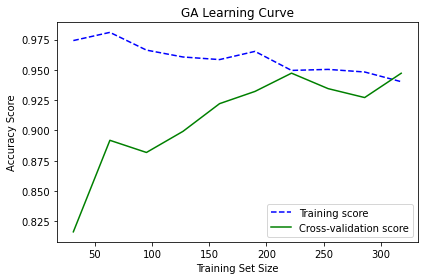

In [36]:
plot.plot_learning_curve(ga_model, X_train_norm, y_train, title="GA Learning Curve")

In [ ]:
ga_model = mlr.NeuralNetwork(
    hidden_nodes=[len(features)],
    is_classifier=True,
    learning_rate=0.1,
    early_stopping=True,
    pop_size=400,
    mutation_prob=0.1,
    random_state=12345,
    algorithm='genetic_alg',
    max_iters=1000,
)
ga_model.